In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def id_splitter(df: pd.DataFrame) -> pd.DataFrame:
    parts = df["id"].str.split("_", expand=True)

    df["item_id"] = parts[0] + '_' + parts[1] + '_' + parts[2]
    df['store_id'] = parts[3] + '_' + parts[4]

    df.drop(columns=['id'], inplace=True)
    df.head()
    return df

In [3]:
calendar = pd.read_csv("data/calendar_afcs2024.csv")
calendar["date"] = pd.to_datetime(calendar["date"])
sell_prices = pd.read_csv("data/sell_prices_afcs2024.csv")
sales_train = id_splitter(pd.read_csv("data/sales_train_validation_afcs2024.csv"))
sales_test = id_splitter(pd.read_csv("data/sales_test_validation_afcs2024.csv"))
sales_test_evaluation = id_splitter(pd.read_csv("data/sales_test_evaluation_afcs_2024.csv"))
sample_submission = id_splitter(pd.read_csv("data/sample_submission_afcs2024.csv"))

In [4]:
prices_calendar = pd.merge(sell_prices, calendar, on="wm_yr_wk")
prices_calendar.head()

store_id      item_id  wm_yr_wk  sell_price       date    weekday  wday  \
0     TX_3  FOODS_3_001     11101        2.28 2011-01-29   Saturday     1   
1     TX_3  FOODS_3_001     11101        2.28 2011-01-30     Sunday     2   
2     TX_3  FOODS_3_001     11101        2.28 2011-01-31     Monday     3   
3     TX_3  FOODS_3_001     11101        2.28 2011-02-01    Tuesday     4   
4     TX_3  FOODS_3_001     11101        2.28 2011-02-02  Wednesday     5   

   month  year event_name_1 event_type_1 event_name_2 event_type_2  snap_TX  
0      1  2011          NaN          NaN          NaN          NaN        0  
1      1  2011          NaN          NaN          NaN          NaN        0  
2      1  2011          NaN          NaN          NaN          NaN        0  
3      2  2011          NaN          NaN          NaN          NaN        1  
4      2  2011          NaN          NaN          NaN          NaN        0

In [5]:
# # Select a sample of unique items for plotting
# # Find a dynamic way to select items based on parameters
# sample_items = merged_data['item_id'].unique()[:5]

# plt.figure(figsize=(14, 8))
# for item in sample_items:
#     item_data = merged_data[merged_data['item_id'] == item]
#     plt.plot(item_data['date'], item_data['sell_price'], label=f'Item: {item}')

# plt.title('Sell Prices of Selected Items Over Time')
# plt.xlabel('Date')
# plt.ylabel('Sell Price')
# plt.legend(loc='upper left')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [6]:
sales_long = sales_train.melt(
    id_vars=["item_id", "store_id"],
    value_vars=[col for col in sales_train.columns if col.startswith("d_")],
    var_name="day",
    value_name="sales",
)

sales_long["day"] = sales_long["day"].str.extract(r"(\d+)").astype(int)

start_date = pd.Timestamp("2011-01-29")
sales_long["date"] = start_date + pd.to_timedelta(sales_long["day"] - 1, unit='d')
sales_long = sales_long.sort_values(by=["item_id", "date"])

train_data = pd.merge(
    sales_long,
    prices_calendar,
    on=["item_id", "store_id", "date"],
    how="left"
)
train_data = train_data.rename(columns={'Unnamed: 0': 'id'})

In [7]:
train_data.head()

item_id store_id  day  sales       date  wm_yr_wk  sell_price  \
0  FOODS_3_001     TX_3    1      0 2011-01-29   11101.0        2.28   
1  FOODS_3_001     TX_3    2      2 2011-01-30   11101.0        2.28   
2  FOODS_3_001     TX_3    3      1 2011-01-31   11101.0        2.28   
3  FOODS_3_001     TX_3    4      3 2011-02-01   11101.0        2.28   
4  FOODS_3_001     TX_3    5      0 2011-02-02   11101.0        2.28   

     weekday  wday  month    year event_name_1 event_type_1 event_name_2  \
0   Saturday   1.0    1.0  2011.0          NaN          NaN          NaN   
1     Sunday   2.0    1.0  2011.0          NaN          NaN          NaN   
2     Monday   3.0    1.0  2011.0          NaN          NaN          NaN   
3    Tuesday   4.0    2.0  2011.0          NaN          NaN          NaN   
4  Wednesday   5.0    2.0  2011.0          NaN          NaN          NaN   

  event_type_2  snap_TX  
0          NaN      0.0  
1          NaN      0.0  
2          NaN      0.0  
3          NaN      1.0  
4          NaN      0.0

In [8]:
price_trend = train_data.groupby("date")["sell_price"].mean()

sales_trend = train_data.groupby("date")["sales"].sum()

event_prices = train_data[train_data["event_name_1"].notnull()].groupby("date")["sell_price"].mean()
event_prices = train_data[train_data["event_name_2"].notnull()].groupby("date")["sell_price"].mean()

item_sales = train_data.groupby("item_id")["sales"].sum().sort_values(ascending=False)

item_prices = train_data.groupby("item_id")["sell_price"].max().sort_values(ascending=False)

top sales

In [9]:
top_items = item_sales.head(10)
top_items

item_id
FOODS_3_586    150122
FOODS_3_090    114854
FOODS_3_252     86632
FOODS_3_555     77673
FOODS_3_377     73797
FOODS_3_030     47976
FOODS_3_202     41551
FOODS_3_714     40650
FOODS_3_587     40306
FOODS_3_694     35152
Name: sales, dtype: int64

top prices

In [10]:
top_prices = item_prices.head(10)
top_prices

item_id
FOODS_3_083    19.48
FOODS_3_298    19.48
FOODS_3_173    13.98
FOODS_3_272    13.68
FOODS_3_110    11.98
FOODS_3_396    11.48
FOODS_3_690     9.98
FOODS_3_244     9.88
FOODS_3_242     9.88
FOODS_3_571     9.44
Name: sell_price, dtype: float64

bottom prices

In [11]:
bottom_prices = item_prices.tail(10)
bottom_prices

item_id
FOODS_3_580    0.25
FOODS_3_007    0.25
FOODS_3_070    0.25
FOODS_3_234    0.25
FOODS_3_547    0.25
FOODS_3_498    0.25
FOODS_3_454    0.25
FOODS_3_816    0.25
FOODS_3_412    0.25
FOODS_3_752    0.25
Name: sell_price, dtype: float64

I think the average does not really say much. I think it would be more useful to look at the extremes. There quite some items with much higher prices. However the volume of small priced items is just too great compared to the expensive items

/Users/joelylin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/joelylin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/joelylin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/joelylin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

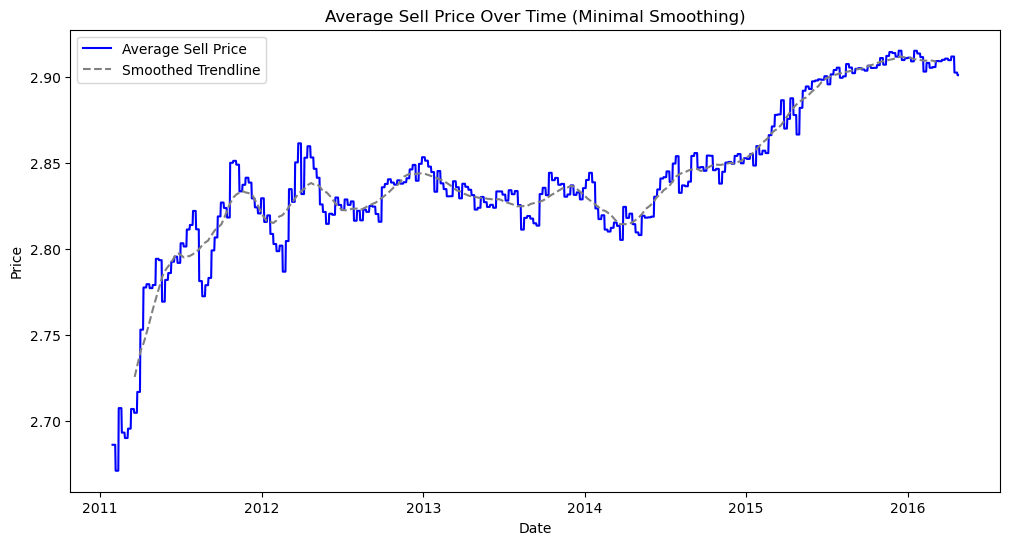

In [12]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    x=price_trend.index,
    y=price_trend.values,
    label="Average Sell Price",
    color="blue",
)
sns.lineplot(
    x=price_trend.index,
    y=price_trend.rolling(window=100, center=True).mean(),
    label="Smoothed Trendline",
    color="grey",
    linestyle="--",
)
plt.title("Average Sell Price Over Time (Minimal Smoothing)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

/Users/joelylin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/joelylin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/joelylin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/joelylin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

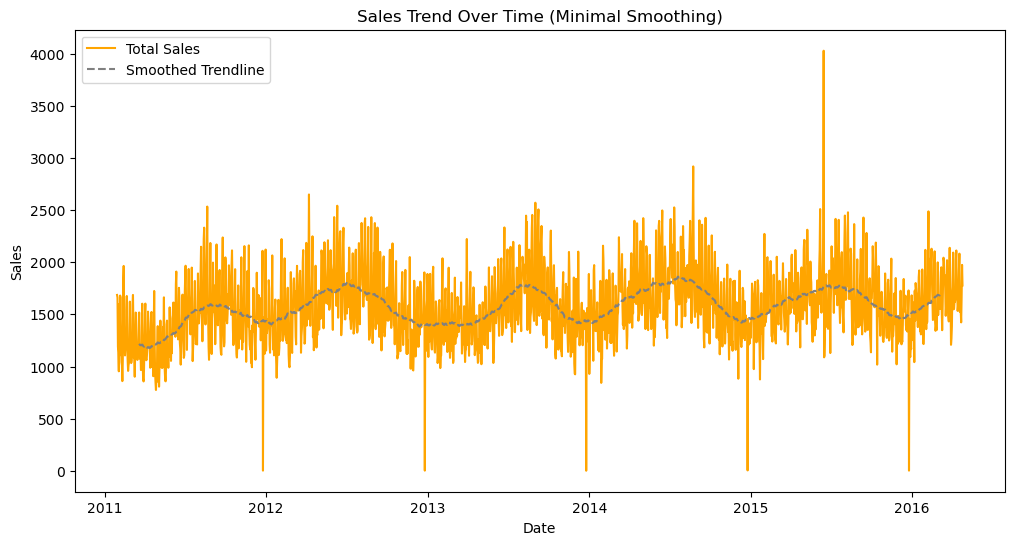

In [13]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    x=sales_trend.index,
    y=sales_trend.values,
    label="Total Sales",
    color="orange",
)
sns.lineplot(
    x=sales_trend.index,
    y=sales_trend.rolling(window=100, center=True).mean(),
    label="Smoothed Trendline",
    color="grey",
    linestyle="--",
)
plt.title("Sales Trend Over Time (Minimal Smoothing)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

/Users/joelylin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/joelylin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/joelylin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


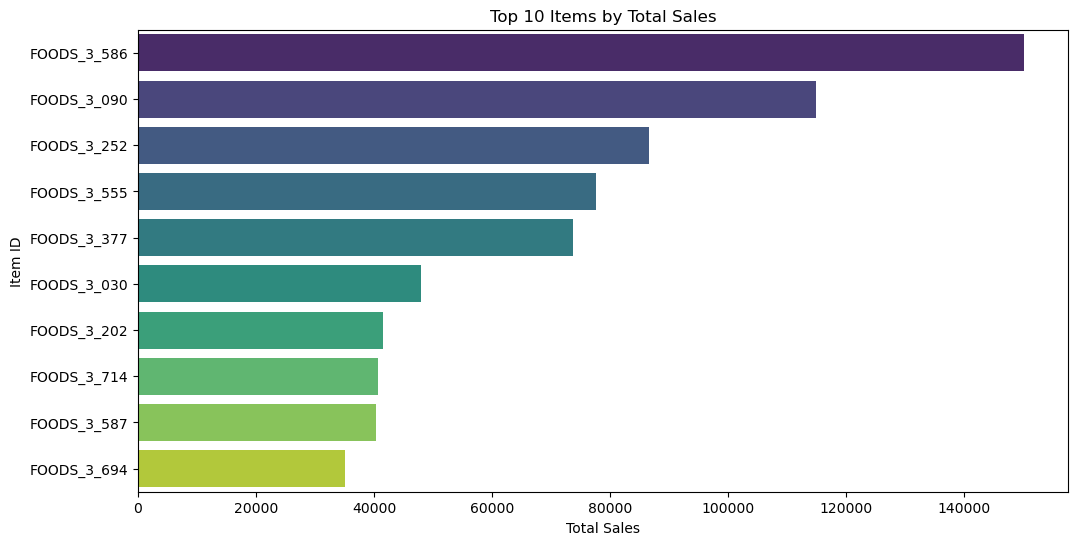

In [14]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_items.values,
    y=top_items.index,
    palette="viridis",
    orient="h",
)
plt.title("Top 10 Items by Total Sales")
plt.xlabel("Total Sales")
plt.ylabel("Item ID")
plt.show()

/Users/joelylin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/joelylin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/joelylin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


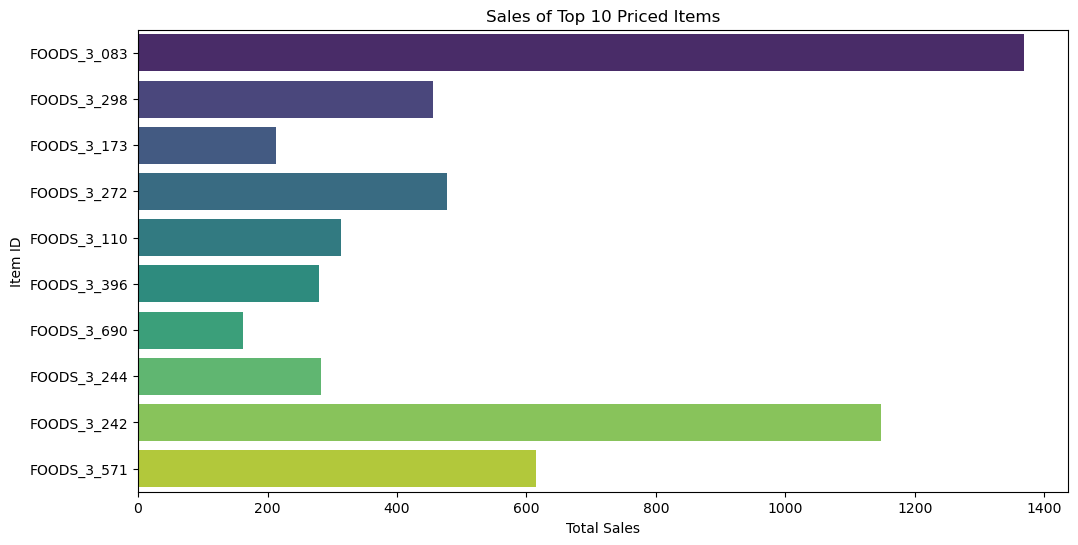

In [15]:
top_prices_ids = top_prices.index.tolist()

# Filter the sales data for the top-priced items
top_price_sales = item_sales.loc[top_prices_ids]

plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_price_sales.values,
    y=top_price_sales.index,
    palette="viridis",
    orient="h",
)
plt.title("Sales of Top 10 Priced Items")
plt.xlabel("Total Sales")
plt.ylabel("Item ID")
plt.show()

/Users/joelylin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/joelylin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/joelylin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


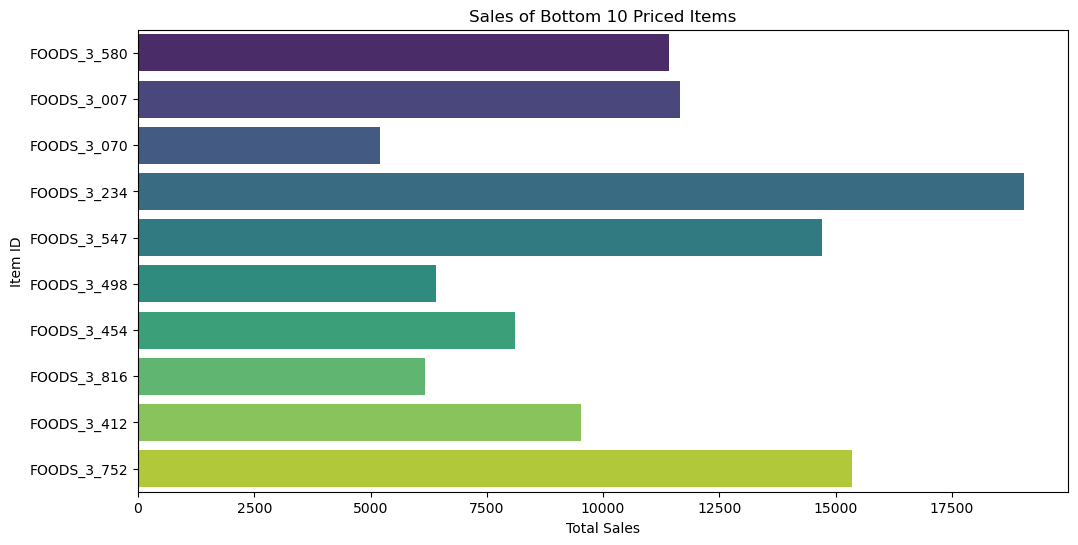

In [16]:
bottom_prices_ids = bottom_prices.index.tolist()

# Filter the sales data for the top-priced items
bottom_price_sales = item_sales.loc[bottom_prices_ids]

plt.figure(figsize=(12, 6))
sns.barplot(
    x=bottom_price_sales.values,
    y=bottom_price_sales.index,
    palette="viridis",
    orient="h",
)
plt.title("Sales of Bottom 10 Priced Items")
plt.xlabel("Total Sales")
plt.ylabel("Item ID")
plt.show()

### Model selection

- Forecasting daily sales for the next 28 days in Texas

### ETS for the sales of all items (since there are signs of trend & seasonality ETS seems like a good choice)

- An additive model seems more appropiate as the seasonal variations and trends are roughly constant throughout the series.
- No sign of explonential growth in the trend or seasonality (multiplicative model).
- Source: https://www.statsmodels.org/dev/examples/notebooks/generated/ets.html

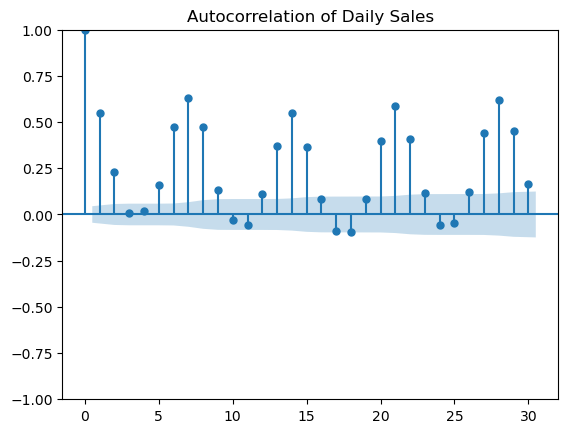

In [17]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(sales_trend, lags=30)
plt.title('Autocorrelation of Daily Sales')
plt.show()
# confirms weekly seasonality

In [18]:
# Creating and fitting the ETS model
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
model = ETSModel(
    sales_trend,
    error="add",
    trend="add",
    seasonal="add",
    seasonal_periods=7,
)
ets_model = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.07835D+00    |proj g|=  9.88789D-01

At iterate    1    f=  6.90159D+00    |proj g|=  1.80490D-01

At iterate    2    f=  6.87661D+00    |proj g|=  2.67633D-01

At iterate    3    f=  6.86938D+00    |proj g|=  2.47582D-01

At iterate    4    f=  6.84809D+00    |proj g|=  9.81264D-02

At iterate    5    f=  6.84711D+00    |proj g|=  9.78488D-02

At iterate    6    f=  6.84487D+00    |proj g|=  1.03179D-01

At iterate    7    f=  6.84224D+00    |proj g|=  1.78774D-01

At iterate    8    f=  6.84055D+00    |proj g|=  2.47836D-02

At iterate    9    f=  6.84044D+00    |proj g|=  6.49054D-02

At iterate   10    f=  6.84038D+00    |proj g|=  4.18629D-03

At iterate   11    f=  6.84038D+00    |proj g|=  6.98375D-04

At iterate   12    f=  6.84038D+00    |proj g|=  2.90079D-04

           * * *

Tit   = 

/Users/joelylin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [19]:
print(ets_model.summary())

                                 ETS Results                                  
Dep. Variable:                  sales   No. Observations:                 1913
Model:                       ETS(AAA)   Log Likelihood              -13085.639
Date:                Thu, 19 Dec 2024   AIC                          26197.278
Time:                        00:10:45   BIC                          26269.511
Sample:                    01-29-2011   HQIC                         26223.860
                         - 04-24-2016   Scale                        51168.252
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.2037      0.019     10.790      0.000       0.167       0.241
smoothing_trend        0.0009        nan        nan        nan         nan         nan
smoothing_seasonal  

In [20]:
ets_forecast = ets_model.forecast(28)
print(ets_forecast.round(2)) 

2016-04-25    1618.92
2016-04-26    1548.05
2016-04-27    1472.72
2016-04-28    1499.24
2016-04-29    1615.55
2016-04-30    1874.12
2016-05-01    1963.16
2016-05-02    1619.67
2016-05-03    1548.80
2016-05-04    1473.47
2016-05-05    1499.99
2016-05-06    1616.30
2016-05-07    1874.87
2016-05-08    1963.91
2016-05-09    1620.43
2016-05-10    1549.55
2016-05-11    1474.22
2016-05-12    1500.74
2016-05-13    1617.05
2016-05-14    1875.62
2016-05-15    1964.66
2016-05-16    1621.18
2016-05-17    1550.30
2016-05-18    1474.98
2016-05-19    1501.50
2016-05-20    1617.81
2016-05-21    1876.38
2016-05-22    1965.42
Freq: D, Name: simulation, dtype: float64


Eval model total daily sales predictions (ETS)

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

eval_sales_test = pd.read_csv("data/sales_test_evaluation_afcs_2024.csv")
daily_sales_sum = eval_sales_test.drop("id", axis=1).sum()
daily_sales_sum_df = daily_sales_sum.reset_index()
daily_sales_sum_df.columns = ["day", "total_sales"]
total_sales_column = daily_sales_sum_df["total_sales"]

y_pred = ets_forecast.values.flatten().astype(int)
y_true = total_sales_column.values.flatten()

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")


MAE: 302.86, RMSE: 355.92


daily sales per item no events prediction model (ETS)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17869D+00    |proj g|=  9.88789D-01

At iterate    1    f=  1.15274D+00    |proj g|=  2.49860D-01

At iterate    2    f=  1.12952D+00    |proj g|=  2.29470D-01

At iterate    3    f=  1.11828D+00    |proj g|=  2.24663D-01

At iterate    4    f=  1.11415D+00    |proj g|=  3.10345D-01

At iterate    5    f=  1.09984D+00    |proj g|=  2.99019D-01

At iterate    6    f=  1.09873D+00    |proj g|=  1.98331D-01

At iterate    7    f=  1.09751D+00    |proj g|=  1.00454D-01

At iterate    8    f=  1.08868D+00    |proj g|=  2.30243D-01

At iterate    9    f=  1.08429D+00    |proj g|=  8.14869D-02

At iterate   10    f=  1.08394D+00    |proj g|=  1.15516D-01

At iterate   11    f=  1.08069D+00    |proj g|=  5.01878D-01

At iterate   12    f=  1.07972D+00    |proj g|=  3.00238D-02

At iterate   13    f=  1.0


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   33    f=  9.42508D-01    |proj g|=  2.24743D-01

At iterate   34    f=  9.42498D-01    |proj g|=  2.13214D-01

At iterate   35    f=  9.42487D-01    |proj g|=  3.88608D-01

At iterate   36    f=  9.42458D-01    |proj g|=  2.32614D-01

At iterate   37    f=  9.42441D-01    |proj g|=  9.84591D-03

At iterate   38    f=  9.42440D-01    |proj g|=  4.42478D-02

At iterate   39    f=  9.42439D-01    |proj g|=  5.19482D-02

At iterate   40    f=  9.42436D-01    |proj g|=  6.25108D-02

At iterate   41    f=  9.42429D-01    |proj g|=  6.14924D-02

At iterate   42    f=  9.42416D-01    |proj g|=  8.63542D-02

At iterate   43    f=  9.42381D-01    |proj g|=  7.00245D-02

At iterate   44    f=  9.42379D-01    |proj g|=  1.77149D-02

At iterate   45    f=  9.42368D-01    |proj g|=  1.12211D-02

At iterate   46    f=  9.42368D-01    |proj g|=  3.18018D-02

At iterate   47    f=  9.42364D-01    |proj g|=  9.32020D-03

At iterate   48    f=  9.42364D-01    |proj g|=  1.30746D-02

At iter

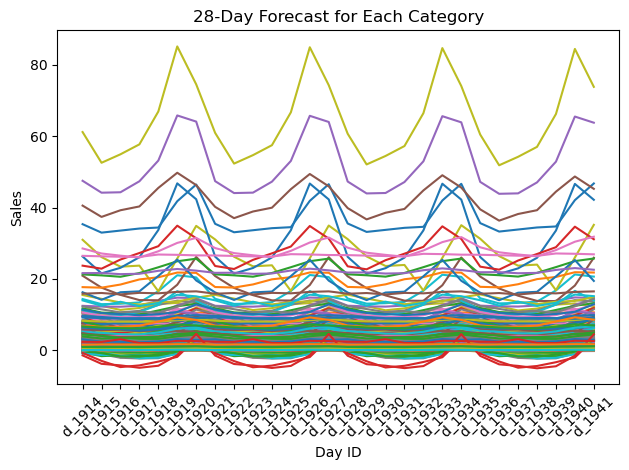

In [47]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

train_data = pd.read_csv("data/sales_train_validation_afcs2024.csv")

# print(train_data.head())

df = pd.DataFrame(train_data)
df.set_index("id", inplace=True)

df_long = df.T.reset_index().rename(columns={"index": "day_id"})
df_long["day_id"] = df_long["day_id"].str.extract(r"(\d+)").astype(int) 

train_data.head()

def forecast_category(category_series, forecast_horizon=28):
    model = ETSModel(
        category_series,
        error="add",
        trend="add",
        seasonal="add",
        seasonal_periods=7, 
    )
    fitted_model = model.fit()
    forecast = fitted_model.forecast(steps=forecast_horizon)
    return forecast

forecasts = {}
forecast_horizon = 28


for category in df.index:
    sales_series = df.loc[category].values
    forecasts[category] = forecast_category(sales_series, forecast_horizon)

forecast_df = pd.DataFrame(forecasts)


last_day_id = df_long["day_id"].max()
forecast_df.index = [f"d_{day}" for day in range(last_day_id + 1, last_day_id + 1 + forecast_horizon)]

forecast_output = forecast_df.T
forecast_output.columns = [f"d_{day}" for day in range(last_day_id + 1, last_day_id + 1 + forecast_horizon)]
forecast_output.index.name = "id"

print(forecast_output)

for category in forecast_output.index:
    plt.plot(forecast_output.columns, forecast_output.loc[category], label=category)

plt.title("28-Day Forecast for Each Category")
plt.xlabel("Day ID")
plt.ylabel("Sales")
plt.legend()
plt.xticks(rotation=45)
plt.legend().remove()
plt.tight_layout()
plt.show()


Evaluation sum of daily sales by daily sales per item prediction model (per item and total daily sales)

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


eval_data = pd.read_csv("data/sales_test_evaluation_afcs_2024.csv")
eval_data.set_index("id", inplace=True)
eval_data = eval_data.iloc[:, -28:]
forecast_df.index.name = "id"


y_true = eval_data.values.flatten()
y_pred = forecast_df.values.flatten()

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")


eval_data_daily_sum = eval_data.sum(axis=0)  

forecast_df = forecast_df.iloc[:, -28:] 
forecast_daily_sum = forecast_df.sum(axis=0)  

y_true = eval_data_daily_sum.values
y_pred = forecast_daily_sum.values

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")



ValueError: Found input variables with inconsistent numbers of samples: [23044, 784]

ARIMA (Data Preprocesssing(mostly same as first model) - model train - eval)

In [52]:
calendar = pd.read_csv("data/calendar_afcs2024.csv")
calendar["date"] = pd.to_datetime(calendar["date"])
sell_prices = pd.read_csv("data/sell_prices_afcs2024.csv")
sales_train = id_splitter(pd.read_csv("data/sales_train_validation_afcs2024.csv"))
sales_test = id_splitter(pd.read_csv("data/sales_test_validation_afcs2024.csv"))
sales_test_evaluation = id_splitter(pd.read_csv("data/sales_test_evaluation_afcs_2024.csv"))
sample_submission = id_splitter(pd.read_csv("data/sample_submission_afcs2024.csv"))
prices_calendar = pd.merge(sell_prices, calendar, on="wm_yr_wk")
prices_calendar.head()
sales_long = sales_train.melt(
    id_vars=["item_id", "store_id"],
    value_vars=[col for col in sales_train.columns if col.startswith("d_")],
    var_name="day",
    value_name="sales",
)

sales_long["day"] = sales_long["day"].str.extract(r"(\d+)").astype(int)


start_date = pd.Timestamp("2011-01-29")
sales_long["date"] = start_date + pd.to_timedelta(sales_long["day"] - 1, unit='d')
sales_long["date_numeric"] = (sales_long["date"] - start_date).dt.days

sales_long = sales_long.sort_values(by=["item_id", "date"])

train_data = pd.merge(
    sales_long,
    prices_calendar,
    on=["item_id", "store_id", "date"],
    how="left"
)
train_data = train_data.rename(columns={'Unnamed: 0': 'id'})
train_data.head()
print(train_data.dtypes)

item_id                 object
store_id                object
day                      int64
sales                    int64
date            datetime64[ns]
date_numeric             int64
wm_yr_wk               float64
sell_price             float64
weekday                 object
wday                   float64
month                  float64
year                   float64
event_name_1            object
event_type_1            object
event_name_2            object
event_type_2            object
snap_TX                float64
dtype: object


In [53]:

# Keep the relevant columns 
columns_to_keep = ['item_id','date_numeric', 'weekday', 'event_name_1', 'event_type_1', 
                   'event_name_2', 'event_type_2', 'sales', 'wm_yr_wk', 
                   'sell_price', 'wday', 'month', 'year', 'snap_TX']


train_data_clean = train_data[columns_to_keep]


# Step 4: Convert relevant columns to numeric
train_data_clean[['sales', 'wm_yr_wk', 'sell_price', 'wday', 'month', 'year', 'snap_TX']] = \
    train_data_clean[['sales', 'wm_yr_wk', 'sell_price', 'wday', 'month', 'year', 'snap_TX']].apply(pd.to_numeric, errors='coerce')

train_data_clean['item_id'] = train_data_clean['item_id'].astype('category')
train_data_clean['weekday'] = train_data_clean['weekday'].astype('category')
train_data_clean['event_name_1'] = train_data_clean['event_name_1'].astype('category')
train_data_clean['event_type_1'] = train_data_clean['event_type_1'].astype('category')
train_data_clean['event_name_2'] = train_data_clean['event_name_2'].astype('category')
train_data_clean['event_type_2'] = train_data_clean['event_type_2'].astype('category')

# train_data_clean['item_id'] = train_data_clean['item_id'].cat.codes
# train_data_clean['weekday'] = train_data_clean['weekday'].cat.codes
# train_data_clean['event_name_1'] = train_data_clean['event_name_1'].cat.codes
# train_data_clean['event_type_1'] = train_data_clean['event_type_1'].cat.codes
# train_data_clean['event_name_2'] = train_data_clean['event_name_2'].cat.codes
# train_data_clean['event_type_2'] = train_data_clean['event_type_2'].cat.codes

print(train_data_clean.head(20))



/var/folders/vz/nscl109x0h1d_bxjn6qs3wsm0000gn/T/ipykernel_99709/781439459.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_clean[['sales', 'wm_yr_wk', 'sell_price', 'wday', 'month', 'year', 'snap_TX']] = \
/var/folders/vz/nscl109x0h1d_bxjn6qs3wsm0000gn/T/ipykernel_99709/781439459.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_clean['item_id'] = train_data_clean['item_id'].astype('category')
/var/folders/vz/nscl109x0h1d_bxjn6qs3wsm0000gn/T/ipykernel_99709/781439459.py:15: Set

        item_id  date_numeric    weekday   event_name_1 event_type_1  \
0   FOODS_3_001             0   Saturday            NaN          NaN   
1   FOODS_3_001             1     Sunday            NaN          NaN   
2   FOODS_3_001             2     Monday            NaN          NaN   
3   FOODS_3_001             3    Tuesday            NaN          NaN   
4   FOODS_3_001             4  Wednesday            NaN          NaN   
5   FOODS_3_001             5   Thursday            NaN          NaN   
6   FOODS_3_001             6     Friday            NaN          NaN   
7   FOODS_3_001             7   Saturday            NaN          NaN   
8   FOODS_3_001             8     Sunday      SuperBowl     Sporting   
9   FOODS_3_001             9     Monday            NaN          NaN   
10  FOODS_3_001            10    Tuesday            NaN          NaN   
11  FOODS_3_001            11  Wednesday            NaN          NaN   
12  FOODS_3_001            12   Thursday            NaN         

/var/folders/vz/nscl109x0h1d_bxjn6qs3wsm0000gn/T/ipykernel_99709/781439459.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_clean['event_type_2'] = train_data_clean['event_type_2'].astype('category')


In [54]:
# model = ETSModel(
#     train_data_clean.values.flatten(),
#     error="add",
#     trend="add",
#     seasonal="add",
#     seasonal_periods=7,
# )
# ets_model = model.fit()

# ets_forecast_clean = ets_model.forecast(28)
# print(ets_forecast_clean.round(2)) 

from statsmodels.tsa.arima.model import ARIMA

# Initialize a dictionary to store forecasts per item_id
item_forecasts = {}

# Loop through each unique item_id
for item_id in train_data_clean['item_id'].unique():
    # Filter the data for each item
    item_data = train_data_clean[train_data_clean['item_id'] == item_id]

    # Fit the ARIMA model (adjust order (p, d, q) based on your data)
    arima_model = ARIMA(item_data['sales'], order=(5, 1, 0))  # need fix
    arima_fitted = arima_model.fit()

    forecast = arima_fitted.forecast(steps=28)

    item_forecasts[item_id] = forecast

# Convert the dictionary of forecasts into a DataFrame
forecast_df = pd.DataFrame.from_dict(item_forecasts, orient='index')

forecast_df.columns = [f"forecast_day_{i+1}" for i in range(28)]

print(forecast_df.round(0))




/Users/joelylin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/joelylin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/joelylin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/joelylin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/joelylin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: Future

             forecast_day_1  forecast_day_2  forecast_day_3  forecast_day_4  \
FOODS_3_001             2.0             1.0             2.0             2.0   
FOODS_3_002             0.0             0.0             0.0             0.0   
FOODS_3_003             0.0             0.0             0.0             0.0   
FOODS_3_004             0.0             0.0             0.0             0.0   
FOODS_3_005             1.0             1.0             1.0             1.0   
...                     ...             ...             ...             ...   
FOODS_3_823             1.0             1.0             1.0             1.0   
FOODS_3_824             0.0             0.0             0.0             0.0   
FOODS_3_825             1.0             1.0             1.0             2.0   
FOODS_3_826             2.0             2.0             2.0             2.0   
FOODS_3_827             1.0             1.0             1.0             1.0   

             forecast_day_5  forecast_day_6  foreca

/Users/joelylin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/joelylin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [55]:
# print(forecast_df.round(0))

eval_sales_test = pd.read_csv("data/sales_test_evaluation_afcs_2024.csv")
daily_sales_sum = eval_sales_test.drop("id", axis=1)
y_pred = forecast_df.round(0).values.flatten() #round to 0 cause only whole items can be sold
y_true = daily_sales_sum.values.flatten()

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# print(y_pred.shape)

eval_sales_test = pd.read_csv("data/sales_test_evaluation_afcs_2024.csv")
eval_sales_test.set_index("id", inplace=True)
eval_data_daily_sum = eval_data.sum(axis=0)  

forecast_df = forecast_df.iloc[:, -28:] 
forecast_daily_sum = forecast_df.sum(axis=0)  

y_true = eval_data_daily_sum.values
y_pred = forecast_daily_sum.round(0).values

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 1.78, RMSE: 4.18
MAE: 284.00, RMSE: 348.37


In [ ]:
# from statsmodels.tsa.exponential_smoothing.ets import ETSModel
# import pandas as pd
# import matplotlib.pyplot as plt


# # Function to forecast with ETS and include event
# def forecast_category_with_event(category_series, event_series, price_series, weekday_series, snap_series, forecast_horizon=28):
#     # Adjust the series for events and features (simple example)
#     adjusted_series = category_series + event_series * 10  # Event effect multiplied by a factor
#     adjusted_series = adjusted_series + price_series * 0.5  # Price effect (example)
    
#     # Include more adjustments for weekday and snap_TX as needed
#     adjusted_series = adjusted_series + weekday_series * 2  # Weekday effect (example)
    
#     # Fit ETS model with error, trend, and seasonal components
#     model = ETSModel(
#         adjusted_series,
#         error="add",
#         trend="add",
#         seasonal="add",
#         seasonal_periods=7,
#     )
#     fitted_model = model.fit()
#     forecast = fitted_model.forecast(steps=forecast_horizon)
#     return forecast

# # Forecast for each item_id and store_id
# forecasts = {}
# forecast_horizon = 28

# for (item_id, store_id), group in train_data.groupby(["item_id", "store_id"]):
#     sales_series = group["sales"].values
#     event_series = group["event_name_1"].notna().astype(int).values  # Binary event indicator
#     price_series = group["sell_price"].values
#     weekday_series = group["weekday"].apply(lambda x: pd.to_datetime(x, format='%A').weekday()).values  # Convert weekday name to weekday index
#     snap_series = group["snap_TX"].values
    

#     forecasts[(item_id, store_id)] = forecast_category_with_event(
#         sales_series, event_series, price_series, weekday_series, snap_series, forecast_horizon
#     )

# # Convert forecasts into DataFrame
# forecast_df = pd.DataFrame(forecasts)

# # Adjust forecast output
# last_day_id = train_data["day"].max()
# forecast_df.index = [f"d_{day}" for day in range(last_day_id + 1, last_day_id + 1 + forecast_horizon)]

# forecast_output = forecast_df.T
# forecast_output.columns = [f"d_{day}" for day in range(last_day_id + 1, last_day_id + 1 + forecast_horizon)]
# forecast_output.index.name = "id"

# # Print forecast output
# print(forecast_output)

# # Plot the forecasted values for each (item_id, store_id)
# for (item_id, store_id) in forecast_output.index:
#     plt.plot(forecast_output.columns, forecast_output.loc[(item_id, store_id)], label=f"{item_id} - {store_id}")

# plt.title("28-Day Forecast for Each Item/Store Pair with Sales Events")
# plt.xlabel("Day ID")
# plt.ylabel("Sales")
# plt.legend()
# plt.xticks(rotation=45)
# plt.legend().remove()
# plt.tight_layout()
# plt.show()


### Forecasting sales for the priciest item

In [24]:
# Selecting item with the highest price
expensive_item = train_data[(train_data['store_id'] == 'TX_3') & (train_data['item_id'] == 'FOODS_3_083')]

# Aggregating sales by date for this item
expensive_item_sales = expensive_item.groupby('date')['sales'].sum()

# Creating and fitting the ETS model
model_1 = ETSModel(
    expensive_item_sales,
    error='add',
    trend='add',
    seasonal='add',
    seasonal_periods=7  
)
ets_model_1 = model_1.fit()

# Forecasting the next 28 days
forecast_expensive = ets_model_1.forecast(28)
print(forecast_expensive.round(2))

KeyError: 'store_id'

### Forecasting sales for the cheapest item

In [ ]:
# Selecting one of the items with lowest price (there were several with the same price)
cheapest_item = train_data[(train_data['store_id'] == 'TX_3') & (train_data['item_id'] == 'FOODS_3_580')]

# Aggregating sales by date for this item
cheapest_item_sales = cheapest_item.groupby('date')['sales'].sum()

# Creating and fitting the ETS model
model_2 = ETSModel(
    cheapest_item_sales,
    error='add',
    trend='add',
    seasonal='add',
    seasonal_periods=7  
)
ets_model_2 = model_2.fit()

# Forecasting the next 28 days
forecast_cheapest = ets_model_2.forecast(28)
print(forecast_cheapest.round(2))

/Users/joelylin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.67946D+00    |proj g|=  9.88789D-01

At iterate    1    f=  3.67696D+00    |proj g|=  9.19604D-02

At iterate    2    f=  3.65757D+00    |proj g|=  7.02485D-02

At iterate    3    f=  3.65222D+00    |proj g|=  1.06354D-01

At iterate    4    f=  3.65015D+00    |proj g|=  1.72329D-01

At iterate    5    f=  3.64848D+00    |proj g|=  1.22338D-01

At iterate    6    f=  3.64809D+00    |proj g|=  2.31346D-02

At iterate    7    f=  3.64807D+00    |proj g|=  1.30932D-02

At iterate    8    f=  3.64806D+00    |proj g|=  1.11282D-02

At iterate    9    f=  3.64804D+00    |proj g|=  1.10081D-02

At iterate   10    f=  3.64795D+00    |proj g|=  2.33499D-02

At iterate   11    f=  3.64778D+00    |proj g|=  4.90813D-02

At iterate   12    f=  3.64725D+00    |proj g|=  9.30492D-02

At iterate   13    f=  3.6

In [ ]:
# don't understand what the negative sales mean (did i do something wrong?)

### Now lets compare it to the item with the most sales

In [ ]:
# Selecting most sold item 
popular_item = train_data[(train_data['store_id'] == 'TX_3') & (train_data['item_id'] == 'FOODS_3_586')]

# Aggregating sales by date for this item
popular_item_sales = popular_item.groupby('date')['sales'].sum()

# Creating and fitting the ETS model
model_3 = ETSModel(
    popular_item_sales,
    error='add',
    trend='add',
    seasonal='add',
    seasonal_periods=7  
)
ets_model_3 = model_3.fit()

# Forecasting the next 28 days
forecast_popular = ets_model_3.forecast(28)
print(forecast_popular.round(2))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.44435D+00    |proj g|=  9.88789D-01

At iterate    1    f=  4.32898D+00    |proj g|=  1.84058D-01

At iterate    2    f=  4.30012D+00    |proj g|=  1.74106D-01

At iterate    3    f=  4.29522D+00    |proj g|=  1.59404D-01

At iterate    4    f=  4.28768D+00    |proj g|=  1.14397D-01

At iterate    5    f=  4.28767D+00    |proj g|=  1.14071D-01

At iterate    6    f=  4.28411D+00    |proj g|=  7.37433D-02

At iterate    7    f=  4.28195D+00    |proj g|=  1.04313D-01

At iterate    8    f=  4.28038D+00    |proj g|=  9.51748D-02

At iterate    9    f=  4.28034D+00    |proj g|=  4.20357D-03

At iterate   10    f=  4.28033D+00    |proj g|=  4.16005D-03

At iterate   11    f=  4.28031D+00    |proj g|=  3.89733D-03

At iterate   12    f=  4.28025D+00    |proj g|=  4.77840D-03

At iterate   13    f=  4.2

/Users/joelylin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
